In [8]:
import numpy as np
import json, glob, os
import matplotlib.pyplot as plt
import pandas as pd

test_on = 'mp_test'
depth_scale = 100.0
path = f'/data/mint/TPAMI_evaluations/MP/score/ours_difareli++_with_solver/multipie/{test_on}/'
runtime_path = f'/data/mint/TPAMI_evaluations/MP/pred/Ours/ours_difareli++_with_solver/ema_085000/{test_on}/'
ours_runtime_path = f'/data/mint/TPAMI_evaluations/MP/pred/Ours/ours_difareli++_single_shot_eval/ema_300000/{test_on}_data2/'   # Cause we run this on v20 data2

# Read dssim from csv
dssim_df = pd.read_csv(f'./{test_on}_solver.csv')
# print(dssim_df)

score_dict = {'dpmsolver++': {'steps':{}}, 'dpmsolver': {'steps':{}}, 'unipc': {'steps':{}}}
for p in glob.glob(path + '*.json'):
    if str(depth_scale) in p:
        solver_cfg = p.split('/')[-1].split('.json')[0]
        _, _, solver_name, solver_method, solver_step, solver_order, solver_correction, solver_depth_scale = solver_cfg.split('_')
        # score_dict[solver_name]['steps'][int(solver_step)] = {}
        score_dict[solver_name]['steps'][solver_step] = {}
        # print(solver_name, solver_method, solver_step, solver_order, solver_depth_scale)
        with open(p, 'r') as f:
            data = json.load(f)
            for metric in ['mse', 'lpips']:
                # print(data['eval_score'][score].split('+-'))
                mean, sd = data['eval_score'][metric].split('+-')
                mean = float(mean)
                sd = float(sd)
                score_dict[solver_name]['steps'][solver_step][f'mean_{metric}'] = mean
                score_dict[solver_name]['steps'][solver_step][f'sd_{metric}'] = sd
            dssim_value = dssim_df.loc[dssim_df['solver_cfg'] == f'{solver_name}_{solver_method}_{solver_step}_{solver_order}_{solver_correction}_{solver_depth_scale}']['DSSIM'].values[0]
            mean_dssim, sd_dssim = dssim_value.split(': ')[-1].split('+-')
            score_dict[solver_name]['steps'][solver_step]['mean_dssim'] = float(mean_dssim)
            score_dict[solver_name]['steps'][solver_step]['sd_dssim'] = float(sd_dssim)
            runtime_file = glob.glob(f"{runtime_path}/{solver_cfg.split('eval_score_')[-1]}/runtime*")
            # print(runtime_file, f'{runtime_path}/{solver_cfg}')
            with open(runtime_file[0], 'r') as f:
                runtime = json.load(f)
            score_dict[solver_name]['steps'][str(solver_step)]['mean_runtime'] = np.mean(np.array(runtime['rev_time']) + np.array(runtime['relit_time']))
            score_dict[solver_name]['steps'][str(solver_step)]['sd_runtime'] = np.std(np.array(runtime['rev_time']) + np.array(runtime['relit_time']))
                

runtime_dict = {}
plot_step = ['10', '25', '50', '75', '100']
for step in plot_step:
    tmp = []
    for solver in score_dict.keys():
        tmp.append(score_dict[solver]['steps'][str(step)]['mean_runtime'])
        # print(solver, step, score_dict[solver]['steps'][str(step)]['mean_runtime'])
    runtime_dict[step] = {'mean_runtime':np.mean(tmp), 'sd_runtime':(np.mean(tmp))}
 
 
# Single-shot runtime   
ours_runtime_file = glob.glob(f"{ours_runtime_path}/SD{depth_scale}/runtime*")
assert len(ours_runtime_file) == 1
ours_runtime_dict = {}
with open(ours_runtime_file[0], 'r') as f:
    ours_runtime = json.load(f)
# print(ours_runtime.keys())
ours_runtime_dict['ss'] = ours_runtime['mean_relit_time']

# DDIM 1000 steps runtime
ours_runtime_file = glob.glob(f"{ours_runtime_path}/SD{depth_scale}/runtime*")
assert len(ours_runtime_file) == 1
ours_runtime_dict = {}
with open(ours_runtime_file[0], 'r') as f:
    ours_runtime = json.load(f)
# print(ours_runtime.keys())
ours_runtime_dict['ss'] = ours_runtime['mean_relit_time']

ours_ddim_runtime_file = '/data/mint/sampling/TPAMI/cast_shadows_results_mp/mp_test/ts_1000/log=DiFaReli_FsBg_Sdiff_SS_256_V100_cfg=DiFaReli_FsBg_Sdiff_SS_256_V100_inference.yaml_inv_with_sd_SS_1000ts_shtold_dstC/runtime.json'
with open(ours_ddim_runtime_file, 'r') as f:
    ours_runtime = json.load(f)
ours_runtime_dict['difareli++'] = np.mean(np.stack(ours_runtime['relit_time'])/2) + np.mean(np.stack(ours_runtime['rev_time']))

ours_single_shot = {
    'mean_mse': 0.0075,
    'sd_mse': 0.0077,
    'mean_lpips': 0.1023,
    'sd_lpips': 0.0367,
    'mean_dssim': 0.0590,
    'sd_dssim': 0.0272,
}

ours_ddim_1000ts = {
    'mean_mse': 0.0090,
    'sd_mse': 0.0095,
    'mean_lpips': 0.1043,
    'sd_lpips': 0.0396,
    'mean_dssim': 0.0604,
    'sd_dssim': 0.0296,
}

ours_test_score = {'difareli++':ours_ddim_1000ts, 'ss':ours_single_shot}


['1.35', '3.34', '7.21', '10.25', '13.56']


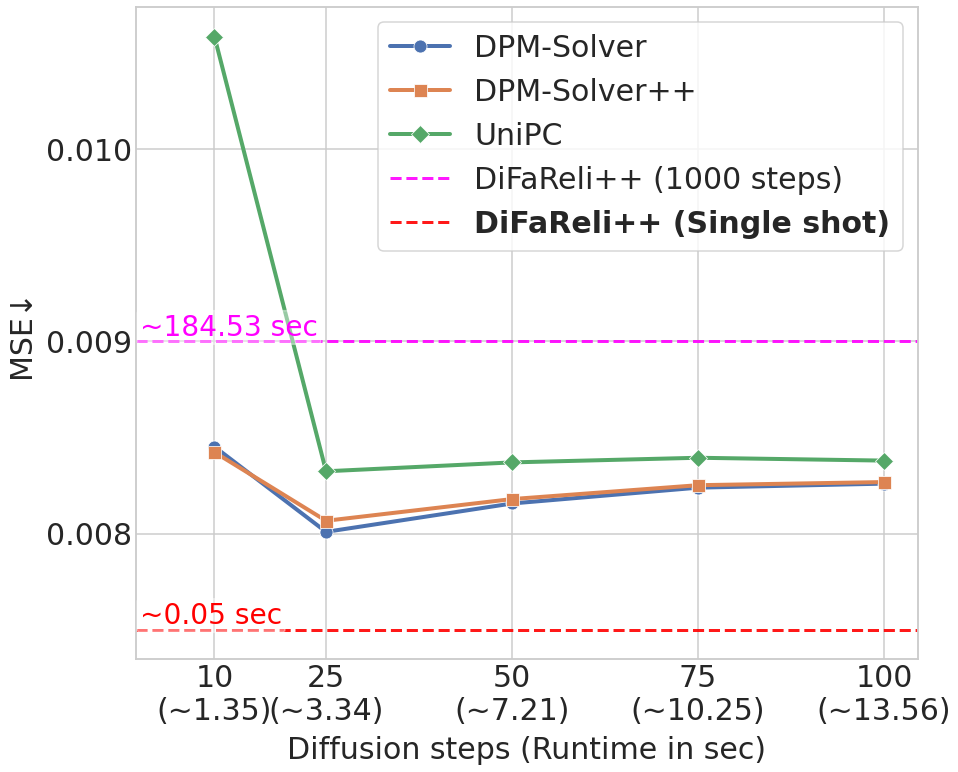

['1.35', '3.34', '7.21', '10.25', '13.56']


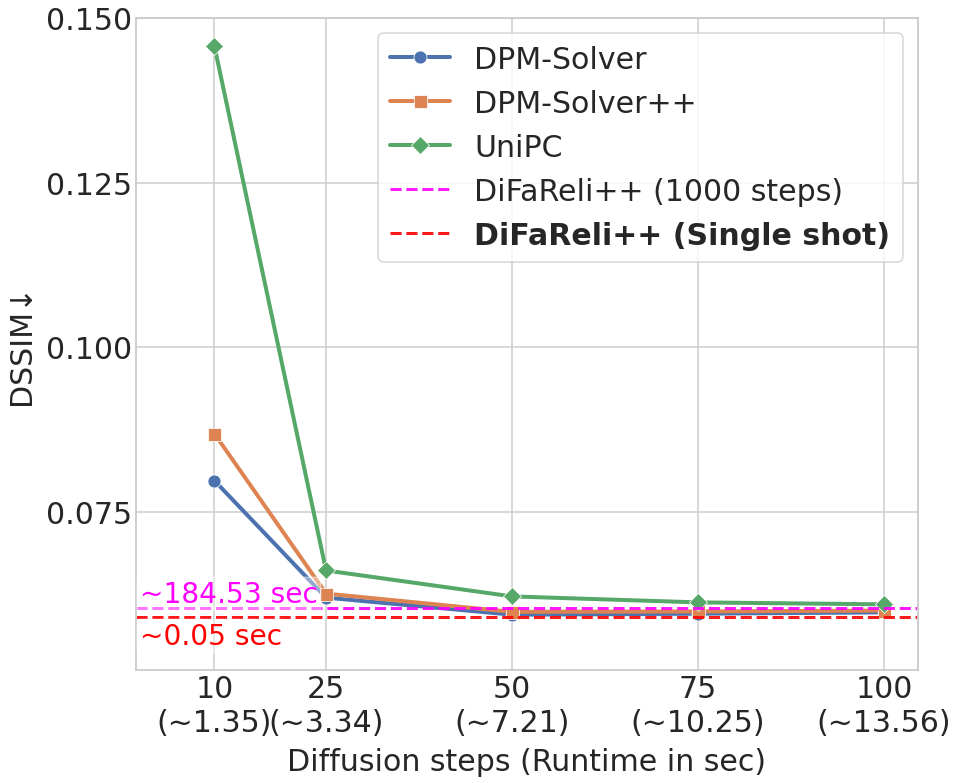

['1.35', '3.34', '7.21', '10.25', '13.56']


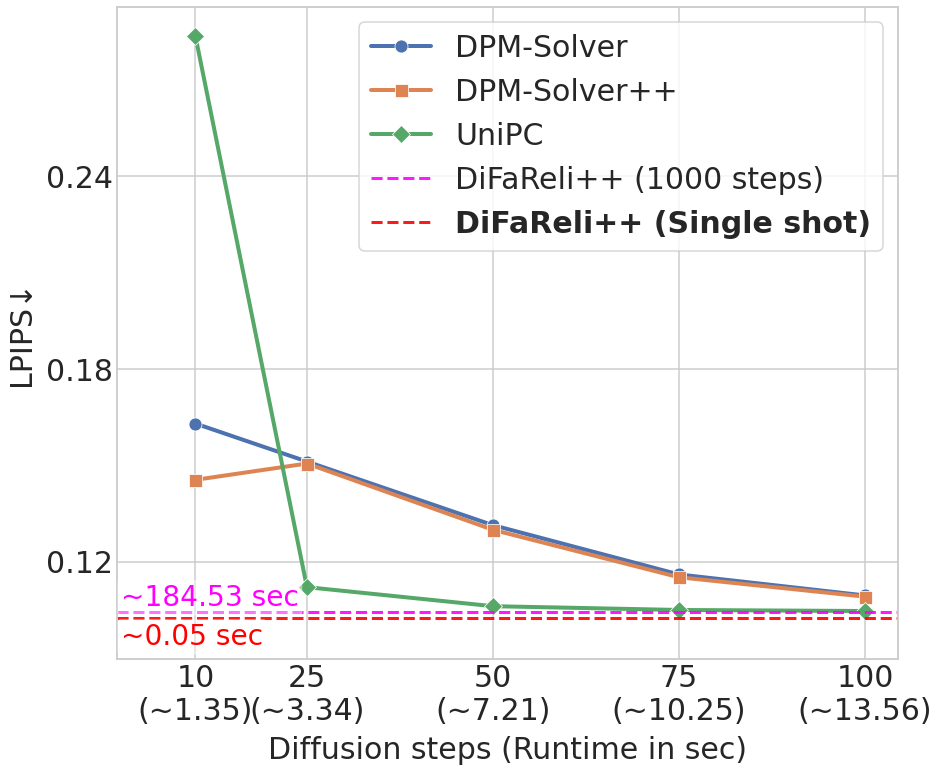

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator
import os
import numpy as np

def plot_seaborn_mp_test(score_dict, ours_test_score, runtime_dict, ours_runtime_dict, test_on, metric, solver_name, solver_label, marker=['o', 's', 'D']):
    # Your data
    plot_step = [10, 25, 50, 75, 100]
    plt.figure(figsize=(14, 12))
    plt.rcParams['font.family'] = 'Calibri'
    sns.set_theme(style="whitegrid")  # Set the theme for Seaborn
    sns.set_context("talk")  # Adjusts the size of the labels, lines, and other elements of the plot# Adjusting text elements
    
    linewidth = 4
    markersize = 13
    fontsize = 30
    tick_fontsize = 30
    

    for i, sn in enumerate(solver_name):
        x = []
        y = []
        for steps in plot_step:
            error = score_dict[sn]['steps'][str(steps)]
            x.append(int(steps))
            y.append(float(error[f'mean_{metric}']))

        sns.lineplot(x=x, y=y, marker=marker[i], linestyle='-', label=solver_label[i], linewidth=linewidth, markersize=markersize)

    # Add titles and labels
    # plt.title(f'{str.upper(metric)} vs. Diffusion steps', fontsize=35)
    plt.xlabel('Diffusion steps (Runtime in sec)', fontsize=fontsize, labelpad=10)
    plt.ylabel(f'{str.upper(metric)}↓', fontsize=fontsize, labelpad=10)
    plt.xticks(fontsize=tick_fontsize)  # Adjust X-axis tick label size
    plt.yticks(fontsize=tick_fontsize)  # Adjust Y-axis tick label size

    plt.tick_params(axis='x', which='major', pad=-5)  # Increase pad for x-axis
    plt.tick_params(axis='y', which='major', pad=-5)  # Increase pad for y-axis
    
    plt.xlim(left=-0.5)
    if metric == 'dssim':
        current_yticks_values, current_yticks_labels = plt.yticks()
        # print(y, x)
        # plt.ylim(bottom=current_yticks_values[0] - 0.01)
        plt.ylim(bottom=np.min(y) - 0.01)
    elif metric == 'lpips':
        current_yticks_values, current_yticks_labels = plt.yticks()
        # print(y, x)
        # plt.ylim(bottom=current_yticks_values[0] - 0.01)
        plt.ylim(bottom=np.min(y) - 0.015)
    
    # current_yticks_values = list(np.array(current_yticks_values) + 0.001)  # Adjust Y-axis tick values
    # plt.yticks(current_yticks_values, [f"{y:.4f}" for y in current_yticks_values])  # Adjust Y-axis tick labels


    runtime_list = [f"{time['mean_runtime']:.2f}" for step, time in runtime_dict.items()]
    print(runtime_list)
    plt.xticks(x, [f"{x_val}\n(~{rt})" for x_val, rt in zip(x, runtime_list)])  # Adjust runtime text here
    plt.gca().yaxis.set_major_locator(MaxNLocator(nbins=4))  # Adjust `nbins` for y-axis ticks
    

    # Adding DiFaReli's baseline
    plt.axhline(y=ours_test_score['difareli++'][f'mean_{metric}'], color='magenta', linestyle='--', label='DiFaReli++ (1000 steps)', linewidth=3, alpha=0.9)
    if metric == 'lpips':
        plt.text(0, ours_test_score['difareli++'][f'mean_{metric}'], f"~{ours_runtime_dict['difareli++']:.2f} sec", 
            ha='left', va='bottom', color='magenta', fontsize=28,
            bbox=dict(facecolor='white', alpha=0.4, edgecolor=None, boxstyle='round,pad=0.1'))
    elif metric == 'dssim':
        plt.text(0, ours_test_score['difareli++'][f'mean_{metric}'], f"~{ours_runtime_dict['difareli++']:.2f} sec", 
            ha='left', va='bottom', color='magenta', fontsize=28,
            bbox=dict(facecolor='white', alpha=0.4, edgecolor=None, boxstyle='round,pad=0.1'))
    else: 
        # plt.text(6.5, ours_test_score['difareli++'][f'mean_{metric}'], '~194.26 sec', 
        plt.text(0, ours_test_score['difareli++'][f'mean_{metric}'], f"~{ours_runtime_dict['difareli++']:.2f} sec", 
            ha='left', va='bottom', color='magenta', fontsize=28,
            bbox=dict(facecolor='white', alpha=0.4, edgecolor=None, boxstyle='round,pad=0.1'))
        
    # plt.text(6, ours_test_score['difareli'][f'mean_{metric}'], '~194.26 sec', ha='left', va='bottom', color='magenta', fontsize=28)
    # plt.text(80, ours_test_score['difareli'][f'mean_{metric}'], '~194.26 sec', ha='left', va='bottom', color='magenta', fontsize=28)

    # Adding single shot (assuming `ours_test_score` is defined outside this function)
    # plt.axhline(y=ours_test_score['ss'][f'mean_{metric}'], color='red', linestyle='--', label='DiFaReli$_{\\mathbf{ss}}$ (1 step)', linewidth=linewidth, alpha=0.9)
    plt.axhline(y=ours_test_score['ss'][f'mean_{metric}'], color='red', linestyle='--', label='DiFaReli++ (Single shot)', linewidth=3, alpha=0.9)
    # plt.text(6.5, ours_test_score['ss'][f'mean_{metric}'], '~0.09 sec', ha='left', va='bottom', color='red', fontsize=tick_fontsize)
    
    if metric == 'lpips':
        # plt.text(80, ours_test_score['ss'][f'mean_{metric}'], '~0.09 sec', 
        plt.text(0, ours_test_score['ss'][f'mean_{metric}'] - 0.01, f"~{ours_runtime_dict['ss']:.2f} sec", 
            ha='left', va='bottom', color='red', fontsize=28,
            bbox=dict(facecolor='white', alpha=0.4, edgecolor=None, boxstyle='round,pad=0.1'))
    elif metric == 'dssim':
        plt.text(0, ours_test_score['ss'][f'mean_{metric}'] - 0.005, f"~{ours_runtime_dict['ss']:.2f} sec", 
            ha='left', va='bottom', color='red', fontsize=28,
            bbox=dict(facecolor='white', alpha=0.4, edgecolor=None, boxstyle='round,pad=0.1'))
    else: 
        # plt.text(6.5, ours_test_score['ss'][f'mean_{metric}'], '~0.09 sec', 
        plt.text(0, ours_test_score['ss'][f'mean_{metric}'], f"~{ours_runtime_dict['ss']:.2f} sec", 
            ha='left', va='bottom', color='red', fontsize=28,
            bbox=dict(facecolor='white', alpha=0.4, edgecolor=None, boxstyle='round,pad=0.1'))
    # plt.text(80, ours_test_score['ss'][f'mean_{metric}'], '~0.09 sec', ha='left', va='bottom', color='red', fontsize=tick_fontsize)

    leg = plt.legend(fontsize=30)  # Adjust legend font size
    for text in leg.get_texts():
        if text.get_text() == 'DiFaReli++ (Single shot)':
            # text.set_color('red')
            text.set_fontweight('bold')
    
    os.makedirs('./roc_curve', exist_ok=True)
    plt.savefig(f'./roc_curve/{test_on}_{metric}.png', bbox_inches='tight', dpi=300)
    plt.show()
    
# plot_seaborn(score_dict, ours_test_score, runtime_dict, ours_runtime_dict, test_on, 'lpips', ['dpmsolver', 'dpmsolver++', 'unipc'], ['DPM-Solver', 'DPM-Solver++', 'UniPC'])
# plot_seaborn(score_dict, ours_test_score, runtime_dict, ours_runtime_dict, test_on, 'dssim', ['dpmsolver', 'dpmsolver++', 'unipc'], ['DPM-Solver', 'DPM-Solver++', 'UniPC'])

plot_seaborn_mp_test(score_dict, ours_test_score, runtime_dict, ours_runtime_dict, test_on, 'mse', ['dpmsolver', 'dpmsolver++', 'unipc'], ['DPM-Solver', 'DPM-Solver++', 'UniPC'])
plot_seaborn_mp_test(score_dict, ours_test_score, runtime_dict, ours_runtime_dict, test_on, 'dssim', ['dpmsolver', 'dpmsolver++', 'unipc'], ['DPM-Solver', 'DPM-Solver++', 'UniPC'])
plot_seaborn_mp_test(score_dict, ours_test_score, runtime_dict, ours_runtime_dict, test_on, 'lpips', ['dpmsolver', 'dpmsolver++', 'unipc'], ['DPM-Solver', 'DPM-Solver++', 'UniPC'])

In [10]:
import numpy as np
import json, glob, os
import matplotlib.pyplot as plt
import pandas as pd

test_on = 'mp_test2'
path = f'/data/mint/TPAMI_evaluations/MP/score/ours_difareli++_with_solver/multipie/{test_on}/'
runtime_path = f'/data/mint/TPAMI_evaluations/MP/pred/Ours/ours_difareli++_with_solver/ema_085000/{test_on}/'
ours_runtime_path = f'/data/mint/TPAMI_evaluations/MP/pred/Ours/ours_difareli++_single_shot_eval/ema_300000/{test_on}_data2/'   # Cause we run this on v20 data2
depth_scale = 100.0
dssim_df = pd.read_csv(f'./{test_on}_solver.csv')

score_dict = {'dpmsolver++': {'steps':{}}, 'dpmsolver': {'steps':{}}, 'unipc': {'steps':{}}}
for p in glob.glob(path + '*.json'):
    if str(depth_scale) in p:
        solver_cfg = p.split('/')[-1].split('.json')[0]
        _, _, solver_name, solver_method, solver_step, solver_order, solver_correction, solver_depth_scale = solver_cfg.split('_')
        # score_dict[solver_name]['steps'][int(solver_step)] = {}
        score_dict[solver_name]['steps'][solver_step] = {}
        # print(solver_name, solver_method, solver_step, solver_order, solver_depth_scale)
        with open(p, 'r') as f:
            data = json.load(f)
            for metric in ['mse', 'lpips']:
                # print(data['eval_score'][score].split('+-'))
                mean, sd = data['eval_score'][metric].split('+-')
                mean = float(mean)
                sd = float(sd)
                score_dict[solver_name]['steps'][solver_step][f'mean_{metric}'] = mean
                score_dict[solver_name]['steps'][solver_step][f'sd_{metric}'] = sd
            dssim_value = dssim_df.loc[dssim_df['solver_cfg'] == f'{solver_name}_{solver_method}_{solver_step}_{solver_order}_{solver_correction}_{solver_depth_scale}']['DSSIM'].values[0]
            mean_dssim, sd_dssim = dssim_value.split(': ')[-1].split('+-')
            score_dict[solver_name]['steps'][solver_step]['mean_dssim'] = float(mean_dssim)
            score_dict[solver_name]['steps'][solver_step]['sd_dssim'] = float(sd_dssim)
            runtime_file = glob.glob(f"{runtime_path}/{solver_cfg.split('eval_score_')[-1]}/runtime*")
            # print(runtime_file, f'{runtime_path}/{solver_cfg}')
            with open(runtime_file[0], 'r') as f:
                runtime = json.load(f)
            score_dict[solver_name]['steps'][str(solver_step)]['mean_runtime'] = np.mean(np.array(runtime['rev_time']) + np.array(runtime['relit_time']))
            score_dict[solver_name]['steps'][str(solver_step)]['sd_runtime'] = np.std(np.array(runtime['rev_time']) + np.array(runtime['relit_time']))

runtime_dict = {}
plot_step = ['10', '25', '50', '75', '100']
for step in plot_step:
    tmp = []
    for solver in score_dict.keys():
        tmp.append(score_dict[solver]['steps'][str(step)]['mean_runtime'])
        # print(solver, step, score_dict[solver]['steps'][str(step)]['mean_runtime'])
    runtime_dict[step] = {'mean_runtime':np.mean(tmp), 'sd_runtime':(np.mean(tmp))}
# print(runtime_dict)

# Single-shot runtime   
ours_runtime_file = glob.glob(f"{ours_runtime_path}/SD{depth_scale}/runtime*")
assert len(ours_runtime_file) == 1
ours_runtime_dict = {}
with open(ours_runtime_file[0], 'r') as f:
    ours_runtime = json.load(f)
# print(ours_runtime.keys())
ours_runtime_dict['ss'] = ours_runtime['mean_relit_time']

# DDIM 1000 steps runtime
ours_runtime_file = glob.glob(f"{ours_runtime_path}/SD{depth_scale}/runtime*")
assert len(ours_runtime_file) == 1
ours_runtime_dict = {}
with open(ours_runtime_file[0], 'r') as f:
    ours_runtime = json.load(f)
# print(ours_runtime.keys())
ours_runtime_dict['ss'] = ours_runtime['mean_relit_time']

ours_ddim_runtime_file = '/data/mint/sampling/TPAMI/cast_shadows_results_mp/mp_test/ts_1000/log=DiFaReli_FsBg_Sdiff_SS_256_V100_cfg=DiFaReli_FsBg_Sdiff_SS_256_V100_inference.yaml_inv_with_sd_SS_1000ts_shtold_dstC/runtime.json'
with open(ours_ddim_runtime_file, 'r') as f:
    ours_runtime = json.load(f)
ours_runtime_dict['difareli++'] = np.mean(np.stack(ours_runtime['relit_time'])/2) + np.mean(np.stack(ours_runtime['rev_time']))

ours_single_shot = {
    'mean_mse': 0.0148,
    'sd_mse': 0.0149,
    'mean_lpips': 0.1123,
    'sd_lpips': 0.0477,
    'mean_dssim': 0.0801,
    'sd_dssim': 0.0418,
}

ours_ddim_1000ts = {
    'mean_mse': 0.0169,
    'sd_mse': 0.0173,
    'mean_lpips': 0.1223,
    'sd_lpips': 0.0506,
    'mean_dssim': 0.0824,
    'sd_dssim': 0.0452,
}

ours_test_score = {'difareli++':ours_ddim_1000ts, 'ss':ours_single_shot}

['1.36', '3.27', '6.96', '10.80', '14.18']


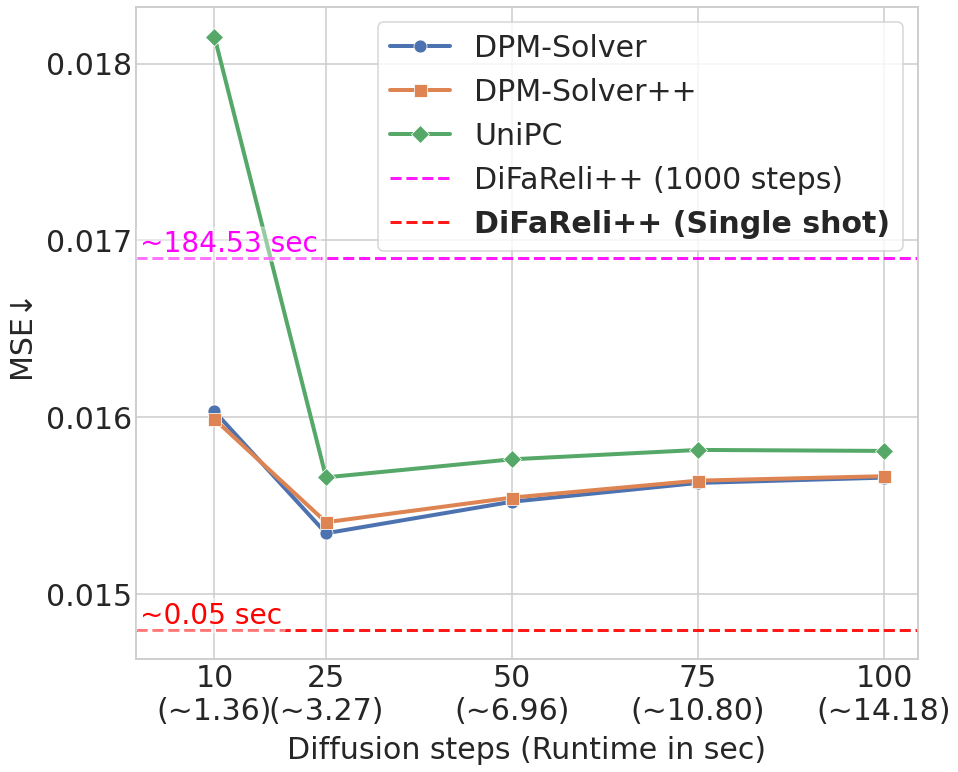

['1.36', '3.27', '6.96', '10.80', '14.18']


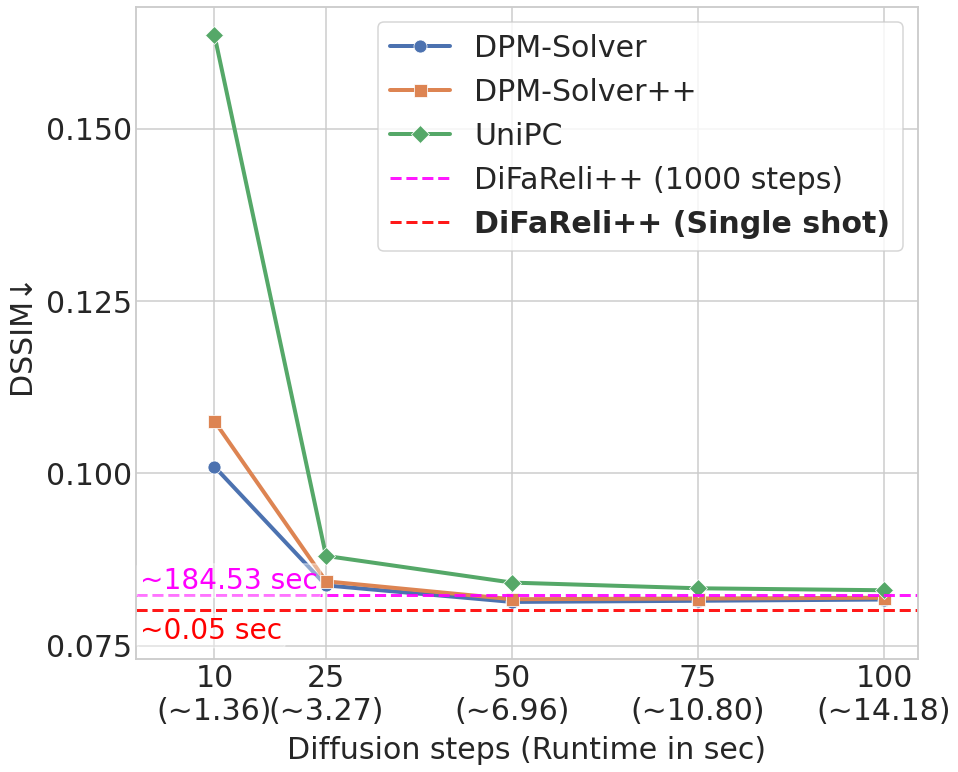

['1.36', '3.27', '6.96', '10.80', '14.18']


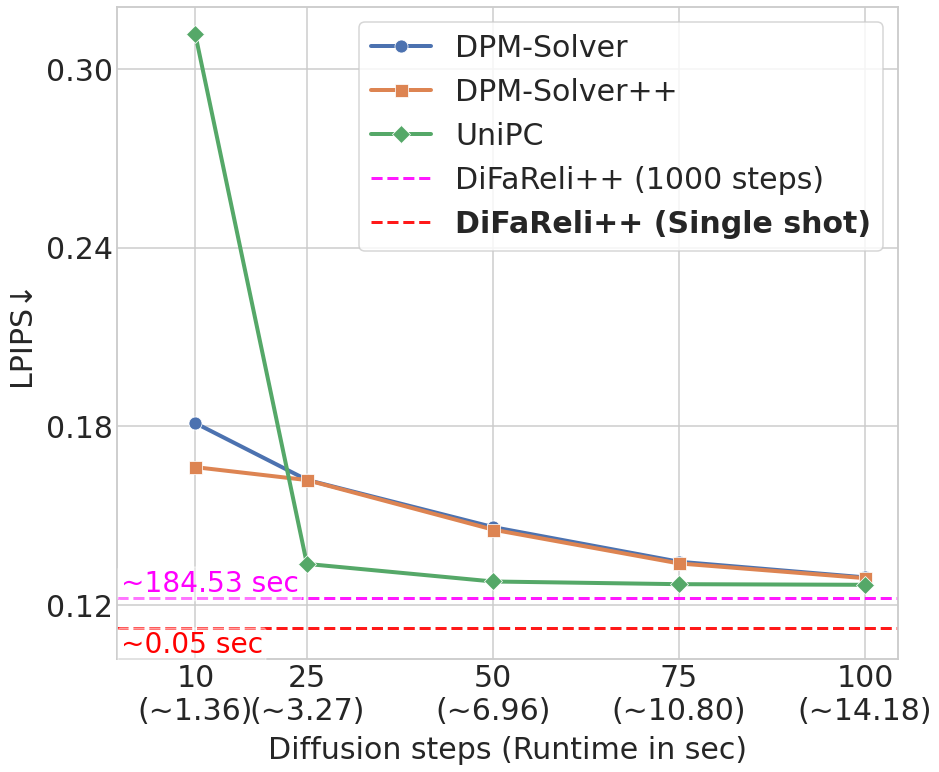

In [13]:

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator
import os
import numpy as np

def plot_seaborn_mp_test2(score_dict, ours_test_score, runtime_dict, ours_runtime_dict, test_on, metric, solver_name, solver_label, marker=['o', 's', 'D']):
    # Your data
    plot_step = [10, 25, 50, 75, 100]
    plt.figure(figsize=(14, 12))
    plt.rcParams['font.family'] = 'Calibri'
    sns.set_theme(style="whitegrid")  # Set the theme for Seaborn
    sns.set_context("talk")  # Adjusts the size of the labels, lines, and other elements of the plot# Adjusting text elements
    
    linewidth = 4
    markersize = 13
    fontsize = 30
    tick_fontsize = 30
    

    for i, sn in enumerate(solver_name):
        x = []
        y = []
        for steps in plot_step:
            error = score_dict[sn]['steps'][str(steps)]
            x.append(int(steps))
            y.append(float(error[f'mean_{metric}']))

        sns.lineplot(x=x, y=y, marker=marker[i], linestyle='-', label=solver_label[i], linewidth=linewidth, markersize=markersize)

    # Add titles and labels
    # plt.title(f'{str.upper(metric)} vs. Diffusion steps', fontsize=35)
    plt.xlabel('Diffusion steps (Runtime in sec)', fontsize=fontsize, labelpad=10)
    plt.ylabel(f'{str.upper(metric)}↓', fontsize=fontsize, labelpad=10)
    plt.xticks(fontsize=tick_fontsize)  # Adjust X-axis tick label size
    plt.yticks(fontsize=tick_fontsize)  # Adjust Y-axis tick label size

    plt.tick_params(axis='x', which='major', pad=-5)  # Increase pad for x-axis
    plt.tick_params(axis='y', which='major', pad=-5)  # Increase pad for y-axis
    plt.xlim(left=-0.5)
    if metric == 'dssim':
        current_yticks_values, current_yticks_labels = plt.yticks()
        # print(y, x)
        # plt.ylim(bottom=current_yticks_values[0] - 0.01)
        plt.ylim(bottom=np.min(y) - 0.01)
    elif metric == 'lpips':
        current_yticks_values, current_yticks_labels = plt.yticks()
        # print(y, x)
        # plt.ylim(bottom=current_yticks_values[0] - 0.01)
        plt.ylim(bottom=np.min(y) - 0.025)
    
    # current_yticks_values = list(np.array(current_yticks_values) + 0.001)  # Adjust Y-axis tick values
    # plt.yticks(current_yticks_values, [f"{y:.4f}" for y in current_yticks_values])  # Adjust Y-axis tick labels


    runtime_list = [f"{time['mean_runtime']:.2f}" for step, time in runtime_dict.items()]
    print(runtime_list)
    plt.xticks(x, [f"{x_val}\n(~{rt})" for x_val, rt in zip(x, runtime_list)])  # Adjust runtime text here
    plt.gca().yaxis.set_major_locator(MaxNLocator(nbins=4))  # Adjust `nbins` for y-axis ticks
    

    # Adding DiFaReli's baseline
    plt.axhline(y=ours_test_score['difareli++'][f'mean_{metric}'], color='magenta', linestyle='--', label='DiFaReli++ (1000 steps)', linewidth=3, alpha=0.9)
    if metric == 'lpips':
        plt.text(0, ours_test_score['difareli++'][f'mean_{metric}'], f"~{ours_runtime_dict['difareli++']:.2f} sec", 
            ha='left', va='bottom', color='magenta', fontsize=28,
            bbox=dict(facecolor='white', alpha=0.4, edgecolor=None, boxstyle='round,pad=0.1'))
    elif metric == 'dssim':
        plt.text(0, ours_test_score['difareli++'][f'mean_{metric}'], f"~{ours_runtime_dict['difareli++']:.2f} sec", 
            ha='left', va='bottom', color='magenta', fontsize=28,
            bbox=dict(facecolor='white', alpha=0.4, edgecolor=None, boxstyle='round,pad=0.1'))
    else: 
        # plt.text(6.5, ours_test_score['difareli++'][f'mean_{metric}'], '~194.26 sec', 
        plt.text(0, ours_test_score['difareli++'][f'mean_{metric}'], f"~{ours_runtime_dict['difareli++']:.2f} sec", 
            ha='left', va='bottom', color='magenta', fontsize=28,
            bbox=dict(facecolor='white', alpha=0.4, edgecolor=None, boxstyle='round,pad=0.1'))
        
    # plt.text(6, ours_test_score['difareli'][f'mean_{metric}'], '~194.26 sec', ha='left', va='bottom', color='magenta', fontsize=28)
    # plt.text(80, ours_test_score['difareli'][f'mean_{metric}'], '~194.26 sec', ha='left', va='bottom', color='magenta', fontsize=28)

    # Adding single shot (assuming `ours_test_score` is defined outside this function)
    # plt.axhline(y=ours_test_score['ss'][f'mean_{metric}'], color='red', linestyle='--', label='DiFaReli$_{\\mathbf{ss}}$ (1 step)', linewidth=linewidth, alpha=0.9)
    plt.axhline(y=ours_test_score['ss'][f'mean_{metric}'], color='red', linestyle='--', label='DiFaReli++ (Single shot)', linewidth=3, alpha=0.9)
    # plt.text(6.5, ours_test_score['ss'][f'mean_{metric}'], '~0.09 sec', ha='left', va='bottom', color='red', fontsize=tick_fontsize)
    
    if metric == 'lpips':
        # plt.text(80, ours_test_score['ss'][f'mean_{metric}'], '~0.09 sec', 
        plt.text(0, ours_test_score['ss'][f'mean_{metric}'] - 0.0105, f"~{ours_runtime_dict['ss']:.2f} sec", 
            ha='left', va='bottom', color='red', fontsize=28,
            bbox=dict(facecolor='white', alpha=0.4, edgecolor=None, boxstyle='round,pad=0.1'))
    elif metric == 'dssim':
        plt.text(0, ours_test_score['ss'][f'mean_{metric}'] - 0.005, f"~{ours_runtime_dict['ss']:.2f} sec", 
            ha='left', va='bottom', color='red', fontsize=28,
            bbox=dict(facecolor='white', alpha=0.4, edgecolor=None, boxstyle='round,pad=0.1'))
    else: 
        # plt.text(6.5, ours_test_score['ss'][f'mean_{metric}'], '~0.09 sec', 
        plt.text(0, ours_test_score['ss'][f'mean_{metric}'], f"~{ours_runtime_dict['ss']:.2f} sec", 
            ha='left', va='bottom', color='red', fontsize=28,
            bbox=dict(facecolor='white', alpha=0.4, edgecolor=None, boxstyle='round,pad=0.1'))
    # plt.text(80, ours_test_score['ss'][f'mean_{metric}'], '~0.09 sec', ha='left', va='bottom', color='red', fontsize=tick_fontsize)

    leg = plt.legend(fontsize=30)  # Adjust legend font size
    for text in leg.get_texts():
        if text.get_text() == 'DiFaReli++ (Single shot)':
            # text.set_color('red')
            text.set_fontweight('bold')
    
    os.makedirs('./roc_curve', exist_ok=True)
    plt.savefig(f'./roc_curve/{test_on}_{metric}.png', bbox_inches='tight', dpi=300)
    plt.show()
    
plot_seaborn_mp_test2(score_dict, ours_test_score, runtime_dict, ours_runtime_dict, test_on, 'mse', ['dpmsolver', 'dpmsolver++', 'unipc'], ['DPM-Solver', 'DPM-Solver++', 'UniPC'])
plot_seaborn_mp_test2(score_dict, ours_test_score, runtime_dict, ours_runtime_dict, test_on, 'dssim', ['dpmsolver', 'dpmsolver++', 'unipc'], ['DPM-Solver', 'DPM-Solver++', 'UniPC'])
plot_seaborn_mp_test2(score_dict, ours_test_score, runtime_dict, ours_runtime_dict, test_on, 'lpips', ['dpmsolver', 'dpmsolver++', 'unipc'], ['DPM-Solver', 'DPM-Solver++', 'UniPC'])

In [14]:
# Examine example of runtime for single-shot
# fn = 'runtime_20241011-160420.json'
fn = 'runtime_20241011-163214.json'
example_runtime = f'/data/mint/sampling/TPAMI/main_result/ffhq/moving_shadows/top_100_min_shadows/log=paired+difareli+cs+nodpm+trainset_256_cfg=paired+difareli+cs+nodpm+trainset_256.yaml_rot2_randmaxC/{fn}'
with open(example_runtime, 'r') as f:
    ex_rt = json.load(f)
print(ex_rt.keys())
# sub_pure_render_deca = np.stack(ex_rt['sub_pure_render_deca_time'])
# sub_pure_render_shadow_time = np.stack(ex_rt['sub_pure_render_shadow_time'])
sub_pure_render_deca = np.stack(ex_rt['all_pure_render_deca_time'])
sub_pure_render_shadow_time = np.stack(ex_rt['all_pure_render_shadow_time'])

print(sub_pure_render_deca.shape, sub_pure_render_shadow_time.shape)

n_frames = 60
print("Mean of render shading reference: ", np.mean(sub_pure_render_deca / n_frames))
print("Mean of render shadow: ", np.mean(sub_pure_render_shadow_time / n_frames))


AssertionError: 